In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

* Carga de datos

In [22]:
df = pd.read_csv('../../../data/heart_disease.csv')
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target
0,52,Male,Typical angina,125,212,Lower than 120 mg/ml,ST-T wave abnormality,168,No,1.0,Downsloping,Two,Reversable Defect,0
1,53,Male,Typical angina,140,203,Greater than 120 mg/ml,Normal,155,Yes,3.1,Upsloping,Zero,Reversable Defect,0
2,70,Male,Typical angina,145,174,Lower than 120 mg/ml,ST-T wave abnormality,125,Yes,2.6,Upsloping,Zero,Reversable Defect,0
3,61,Male,Typical angina,148,203,Lower than 120 mg/ml,ST-T wave abnormality,161,No,0.0,Downsloping,One,Reversable Defect,0
4,62,Female,Typical angina,138,294,Greater than 120 mg/ml,ST-T wave abnormality,106,No,1.9,Flat,Three,Fixed Defect,0


* Exploracion inicial

In [23]:
print("### Información General del Dataset ###")
print(df.info())

print("\n### Resumen de Valores Nulos ###")
print(df.isnull().sum())

### Información General del Dataset ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            1025 non-null   int64  
 1   sex                            1025 non-null   object 
 2   chest_pain_type                1025 non-null   object 
 3   resting_blood_pressure         1025 non-null   int64  
 4   cholestoral                    1025 non-null   int64  
 5   fasting_blood_sugar            1025 non-null   object 
 6   rest_ecg                       1025 non-null   object 
 7   Max_heart_rate                 1025 non-null   int64  
 8   exercise_induced_angina        1025 non-null   object 
 9   oldpeak                        1025 non-null   float64
 10  slope                          1025 non-null   object 
 11  vessels_colored_by_flourosopy  1025 non-null   object 
 12  thalasse

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
resting_blood_pressure,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
cholestoral,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
Max_heart_rate,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2
target,1025.0,0.513171,0.500070,0.0,0.0,1.0,1.0,1.0


* Visualizaciones 

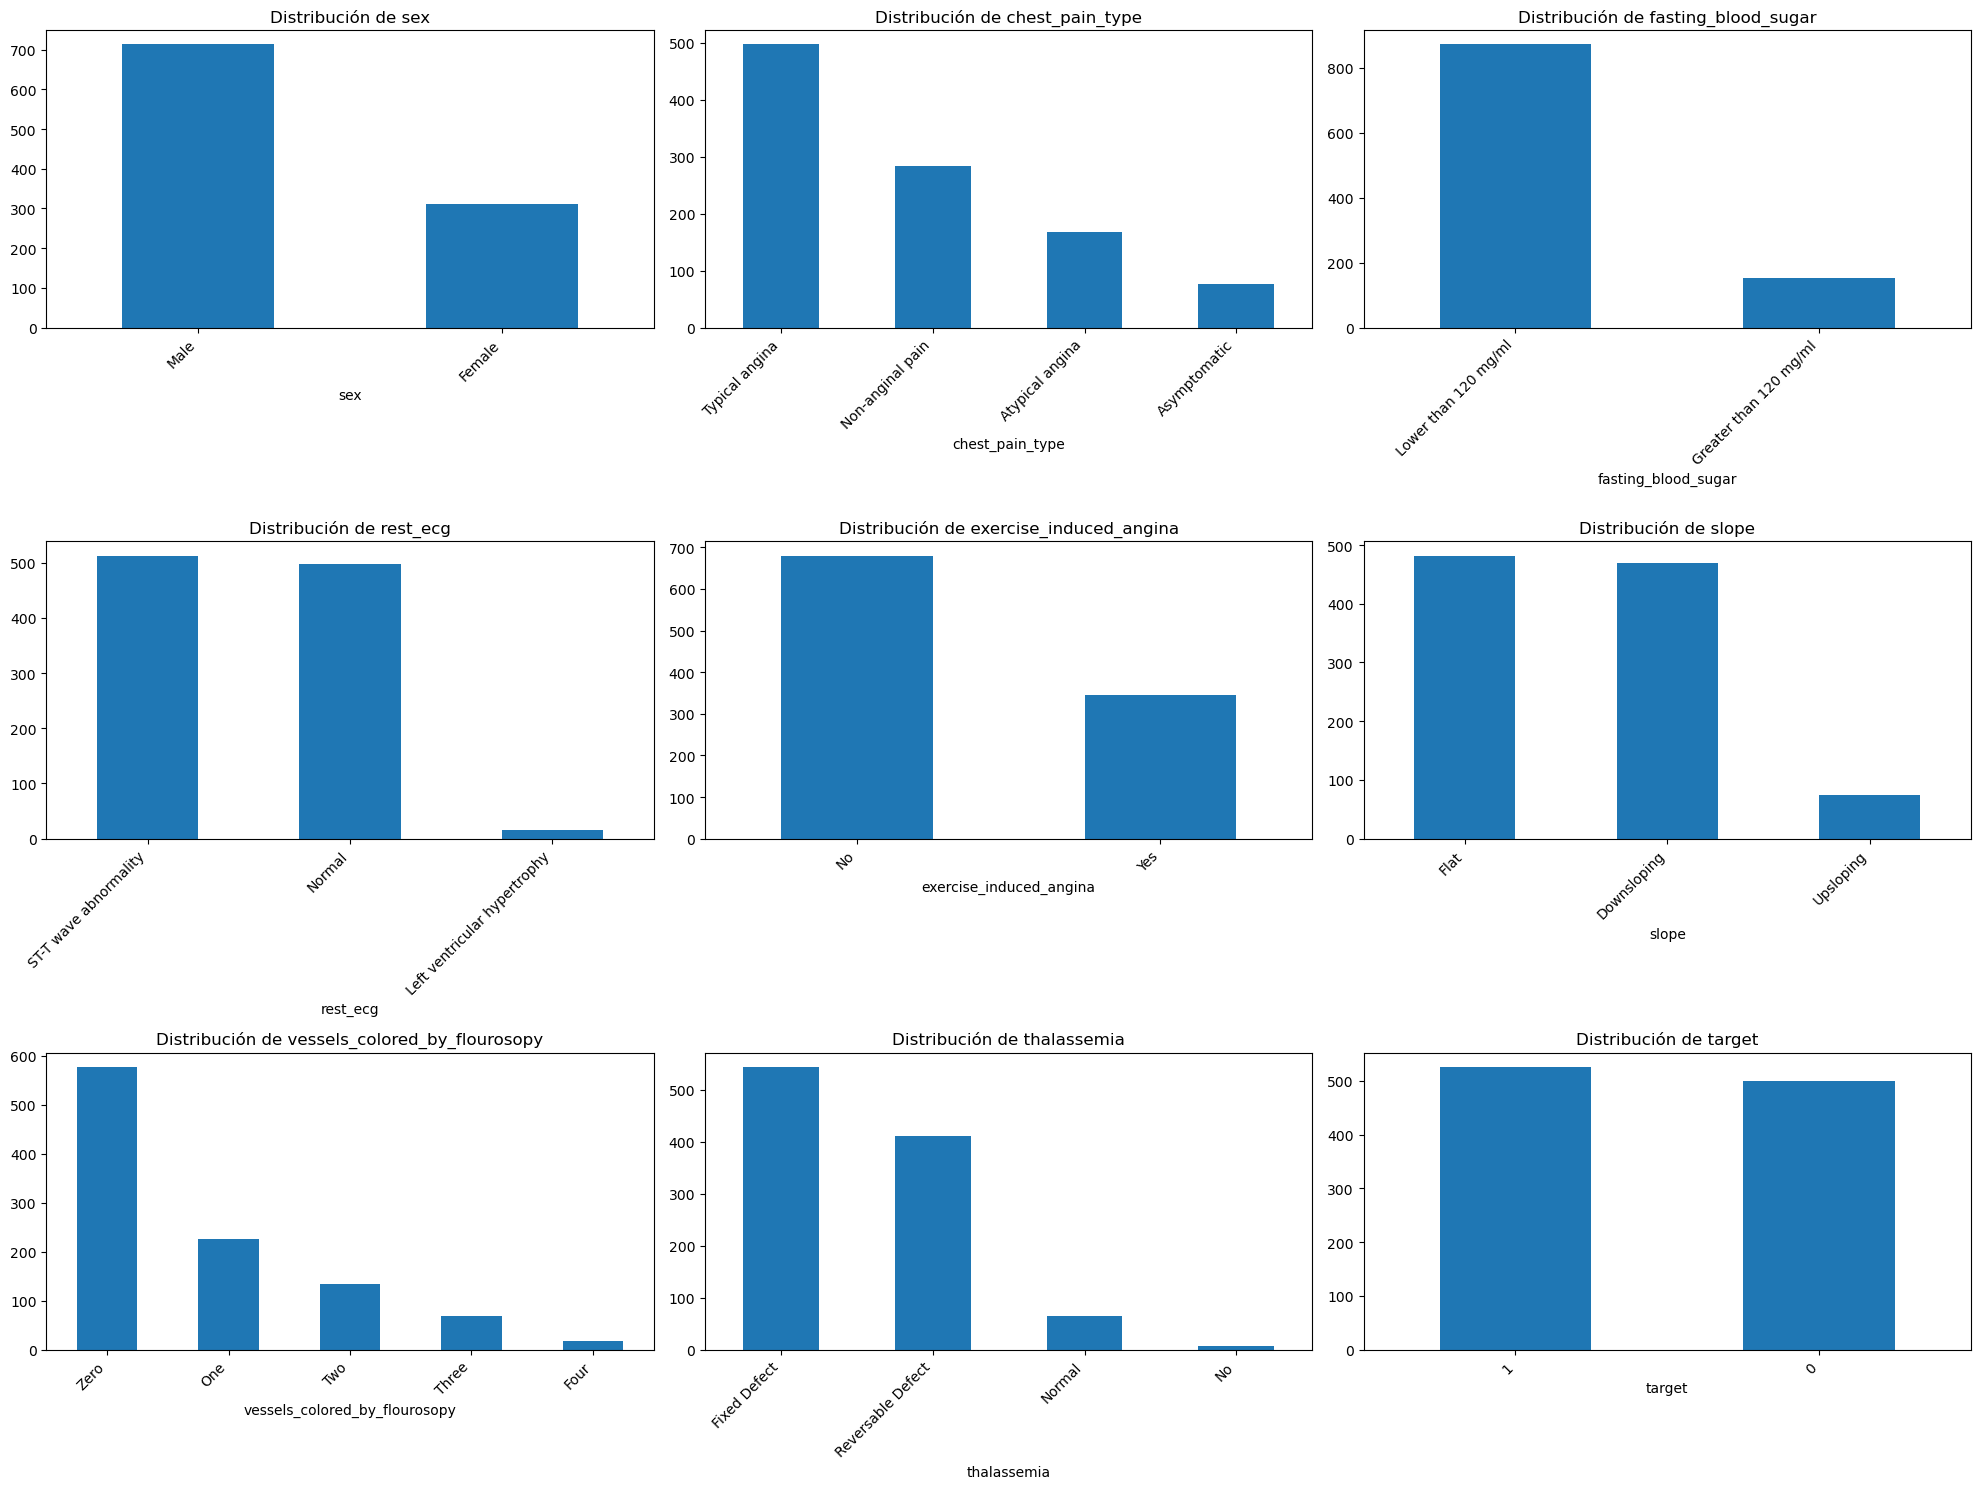

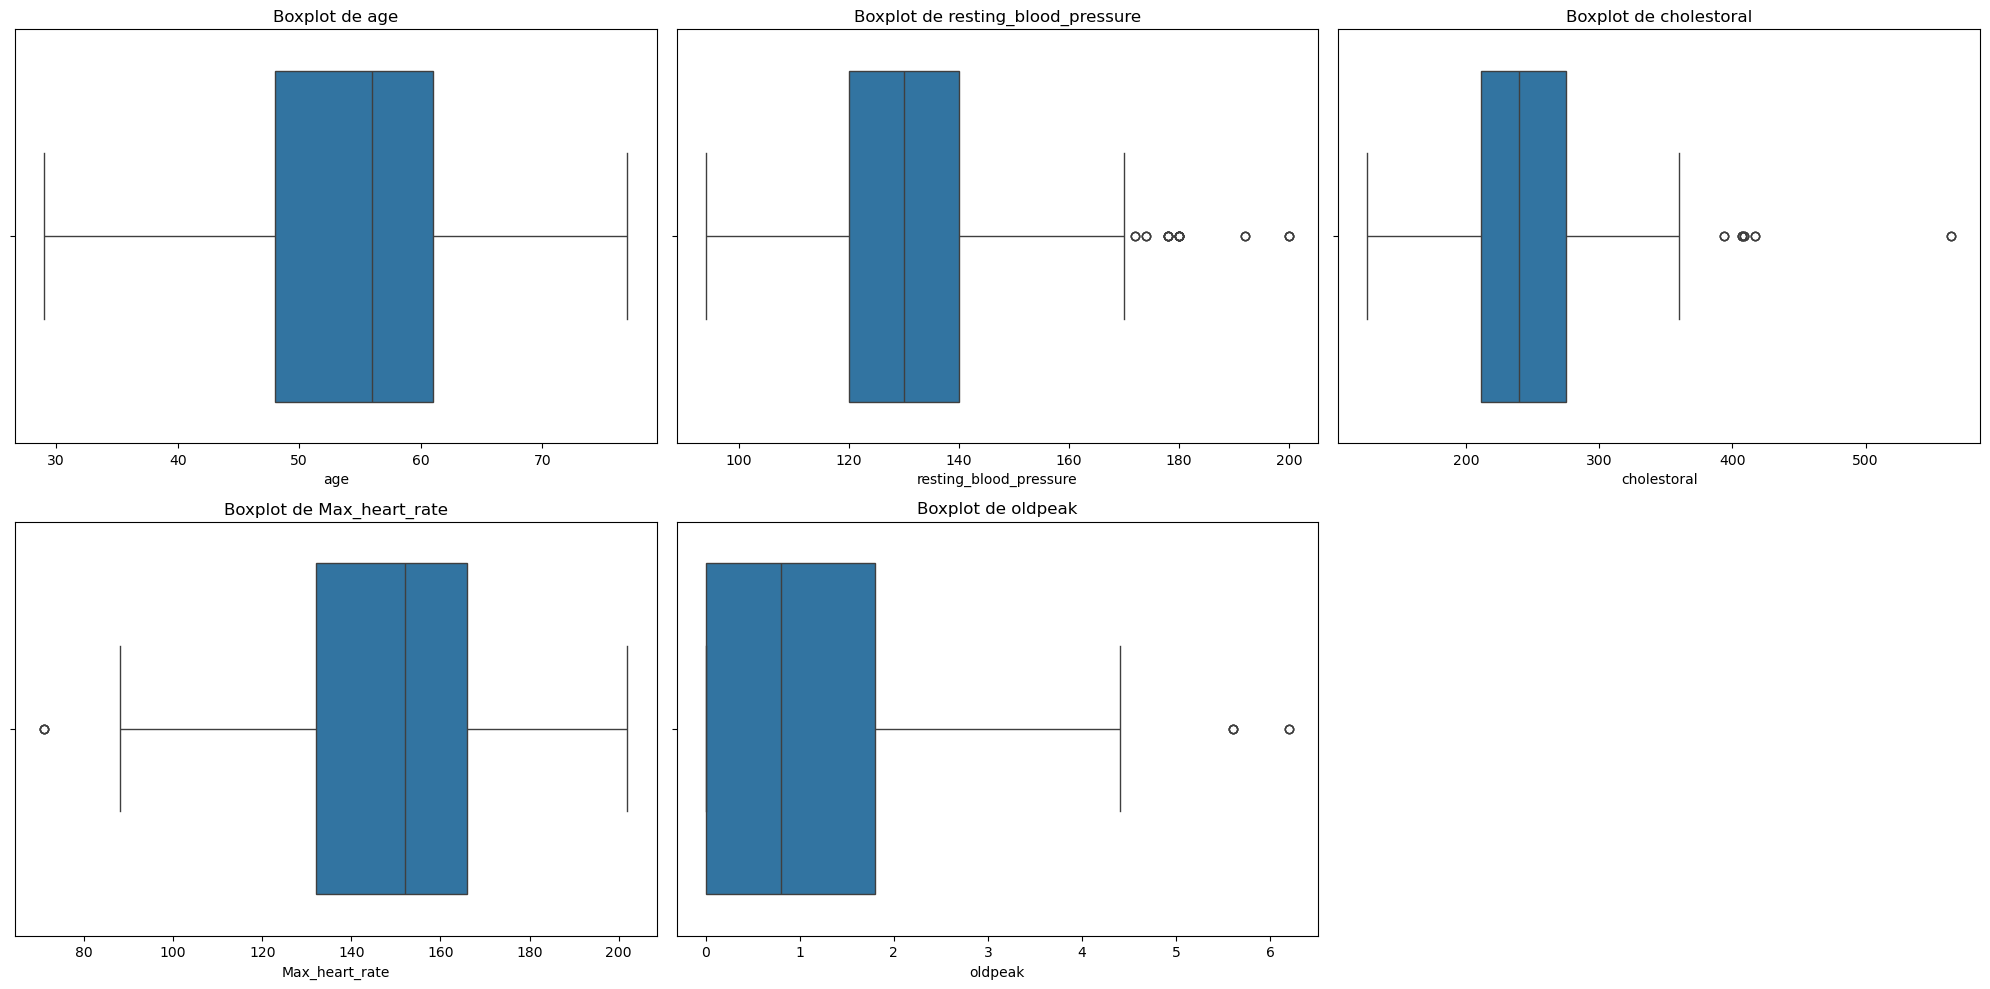

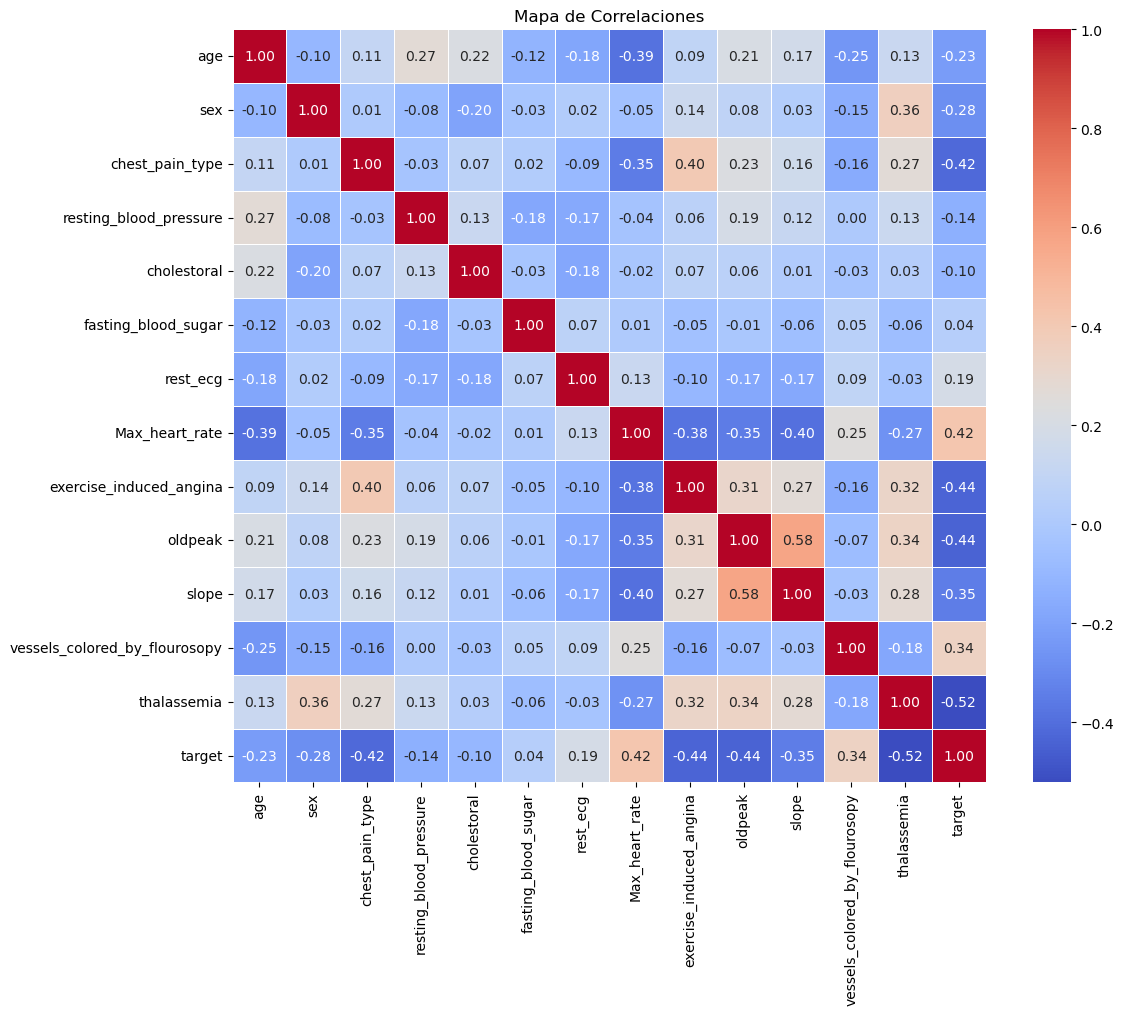

In [25]:
plt.figure(figsize=(20, 15))

# Distribución de variables categóricas
categoricas = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 
                'rest_ecg', 'exercise_induced_angina', 
                'slope', 'vessels_colored_by_flourosopy', 
                'thalassemia', 'target']

for i, columna in enumerate(categoricas, 1):
    plt.subplot(3, 3, i)
    df[columna].value_counts().plot(kind='bar')
    plt.title(f'Distribución de {columna}')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

le = LabelEncoder()

# Columnas a codificar
columnas_a_codificar = [
    'sex', 'chest_pain_type', 'fasting_blood_sugar', 
    'rest_ecg', 'exercise_induced_angina', 
    'slope', 'vessels_colored_by_flourosopy', 
    'thalassemia'
]

# Aplicar Label Encoding
for columna in columnas_a_codificar:
    df[columna] = le.fit_transform(df[columna])

# Detección de outliers
plt.figure(figsize=(20, 10))
numericas = ['age', 'resting_blood_pressure', 'cholestoral', 
                'Max_heart_rate', 'oldpeak']

for i, columna in enumerate(numericas, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[columna])
    plt.title(f'Boxplot de {columna}')
plt.tight_layout()
plt.show()

# Mapa de correlaciones
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', 
            linewidths=0.5, fmt=".2f", square=True)
plt.title('Mapa de Correlaciones')
plt.tight_layout()
plt.show()

* Preprocesamiento

In [26]:
# Definir columnas para transformación
columnas_numericas = ['age', 'resting_blood_pressure', 'cholestoral', 
                        'Max_heart_rate', 'oldpeak']
columnas_categoricas = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 
                            'rest_ecg', 'exercise_induced_angina', 
                            'slope', 'vessels_colored_by_flourosopy', 
                            'thalassemia']

# Preparar características y target
X = df[columnas_numericas + columnas_categoricas]
y = df['target']

# División train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), columnas_categoricas)
    ])

* Seleccion de modelo, hiperparametros y entrenamiento

In [27]:
# 5. Modelo XGBoost con GridSearch
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

# Hiperparámetros para optimización
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.1]
}

# Grid Search
grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, 
    scoring='accuracy', n_jobs=-1
)

# Entrenar modelo
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'resting_blood_pressure',
                                                                          'cholestoral',
                                                                          'Max_heart_rate',
                                                                          'oldpeak']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['sex',
                                                                          'chest_pain_type',
                                                                          'fasting_blood_sugar',
                                                                          'rest_ecg',
                                                                          'exercise_induced_angina',
                                                                          'slope',
                                                                          'vessels_colored_by_f...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1],
                         'classifier__max_depth': [3, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy')

* Evaluacion de modelo


### Mejores Parámetros ###
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}

### Informe de Clasificación ###
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



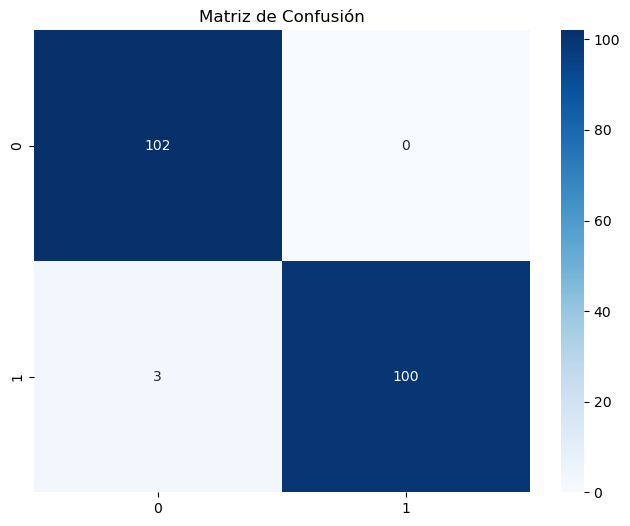

In [28]:
print("\n### Mejores Parámetros ###")
print(grid_search.best_params_)

# Predicciones
y_pred = grid_search.predict(X_test)

# Métricas de rendimiento
print("\n### Informe de Clasificación ###")
print(classification_report(y_test, y_pred))

# Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()